In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wandb

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import wandb

In [ ]:
dataset_path = "/content/drive/MyDrive/7-7 dataset"


In [ ]:
width = height = 299
img_data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255 ,
    validation_split=0.1,
)
train_data= img_data_generator.flow_from_directory(
    dataset_path ,
    shuffle=True,
    subset="training",
    target_size=(width,height),
    batch_size=32
)

validation_data = img_data_generator.flow_from_directory(
    dataset_path,
    shuffle=True,
    subset="validation",
    target_size=(width,height),
    batch_size=32
)

Found 1171 images belonging to 5 classes.
Found 128 images belonging to 5 classes.


## train_data is an iterator , so :

In [ ]:
next(train_data)[0].shape

(32, 299, 299, 3)

In [ ]:
train_images = next(train_data)[0]
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_images[i])

## TransferLearning : weights="imagenet"

In [ ]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , input_shape=(width,height,3))
#initial_model.summary()

## include_top = False :

 ## these 2 layers have been deleted :
 ### because of include_top=False
 avg_pool (GlobalAveragePoo(None,1536))                                                           
 predictions (Dense)(None, 1000)

In [ ]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , include_top=False , input_shape=(width,height,3))
#initial_model.summary()

## حالا خودمون باید اون دوتا لایه رو بسازیم ::
اما لایه پولینگ رو میتونیم اینجوری بسازیم ::
اینجوری فقط لایه دنس را حذف کردیم

In [ ]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                        include_top=False,
                                                        pooling="avg",
                                                        input_shape=(width,height,3))
initial_model.summary()

# FREEZING SOME LAYERS :

نمیخوایم همه ی لایه ها ترین بشن

## اگر بخوایم چهار لایه آخر شبکه فریز نشوند  :
چهارتای آخر را درنظر نمیگیریم
یعنی میخوایم ۴ لایه آخر شبکه ترین بشوند ولی بقیه نه  

In [ ]:
for layer in initial_model.layers[:-4]:
 layer.trainable=False

#initial_model.summary()

In [ ]:
model = tf.keras.models.Sequential([
    initial_model,
    tf.keras.layers.Dropout(0.2), # 0.2 is probability that a neuron will be inactive and 80% active
    tf.keras.layers.Dense(14 , activation="softmax")
])
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001) ,
              loss=tf.keras.losses.categorical_crossentropy ,
              metrics=["accuracy"] )

In [ ]:
run = wandb.init(project="7-7-faces")

In [ ]:
from wandb.sdk.wandb_run import wandb_metric
config = wandb.config
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [ ]:
history = model.fit(train_data , validation_data=validation_data , epochs=10 , callbacks=wandb_callbacks)


| Layers Freezed|without Dropout| with Droput = 0.2 |with Droput = 0.5 |
| ------------- | :-------------: | :-------------: |:-------------: |
| validation Accuracy  | -  | -  | -  |


|without Freezing layers|without Dropout| with Droput = 0.2 | with Droput = 0.5 |
| ------------- | :-------------: | :-------------: | :-------------: |
| validation Accuracy  | -  | -  | -  |


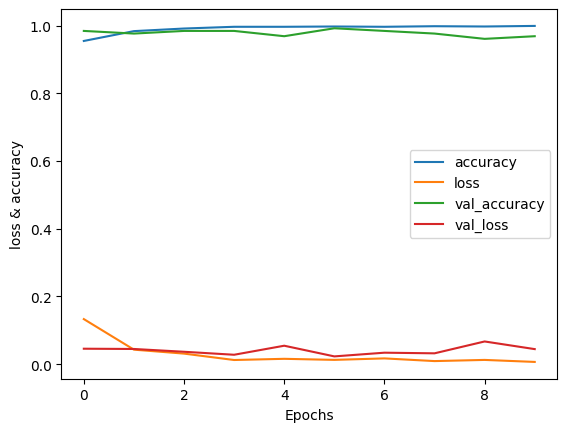

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.plot(history.history["val_loss"])
plt.legend(["accuracy","loss" , "val_accuracy" , "val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.show()

In [ ]:
images,labels = validation_data[1]
ypred_list = []
for image in images:
    image = np.expand_dims(image, axis=0)
    ypred=model.predict(image)
    ypred_list.append(np.argmax(ypred))
ytrue_list = []
for label in labels:
    ytrue_list.append(np.argmax(label))

In [ ]:
np.array(ytrue_list)

array([0, 4, 2, 1, 1, 3, 0, 2, 3, 3, 4, 4, 2, 0, 1, 4, 4, 3, 0, 1, 3, 2,
       0, 4, 0, 1, 4, 0, 4, 0, 4, 1])

In [ ]:
np.array(ypred_list)

array([0, 4, 2, 1, 1, 3, 0, 2, 3, 3, 4, 4, 2, 0, 1, 4, 4, 3, 0, 1, 3, 2,
       0, 4, 0, 1, 4, 0, 4, 0, 4, 1])

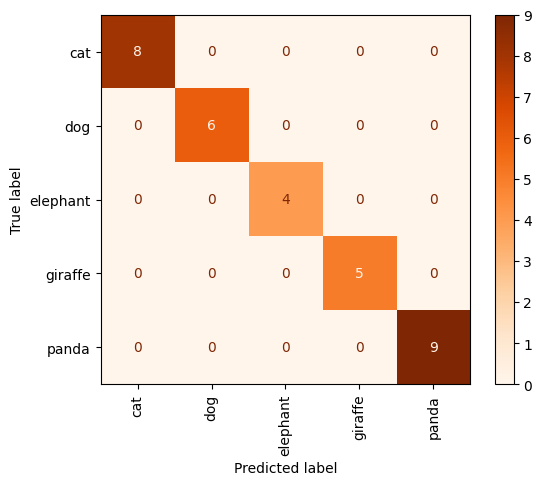

In [ ]:
confm = metrics.confusion_matrix(y_true= ytrue_list , y_pred= ypred_list  )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confm , display_labels=['Ali_Khamenei', 'Angelina_Jolie', 'Barak_Obama', 'Behnam_Bani', 'Donald_Trump', 'Emma_Watson', 'Han_Hye_Jin', 'Kim_Jong_Un', 'Leyla_Hatami', 'Lionel_Messi', 'Michelle_Obama', 'Morgan_Freeman', 'Queen_Elizabeth', 'Scarlett_Johansson'])
cm_display.plot(cmap=plt.cm.Oranges , xticks_rotation="vertical")
plt.show()

# Inference

شبکه همیشه تصاویر را به صورت بچ میخواد از ما . یعنی ورودی شبکه همیشه ۴ بعدی است .
یکی از این ۴ تا بعد بچ سایز است
اما حالا که فقط میخوایم یک تصویر بدیم بازم باید تصویر رو ۴ بعدی بکنیم


In [ ]:
import cv2

new_image = cv2.imread("/content/angelina1.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

In [ ]:
new_image = cv2.imread("/content/trump.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

In [ ]:
new_image = cv2.imread("/content/Obama.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

In [ ]:
new_image = cv2.imread("/content/queen.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])